In [1]:
import numpy as np
import h5py
import pandas as pd

datadict = {}
with h5py.File("EnMAP_Contest_Data.mat", 'r') as f:
    for k, v in f.items():
        datadict[k] = np.array(v)

In [185]:
import numpy as np
import math

class MySOM:
    def __init__(self, datadict, label, nRows, nColumns, iteration, radius, learnrate):
        #init here
        self.datadict = datadict
        self.label = label
        self.nRows = nRows
        self.nColumns = nColumns
        self.radius_max = radius
        self.iteration_max = iteration - 1
        self.learnrate_max = learnrate

    def __str__(self):
        #toString()
        return "label: {0}, dimension: ({1} {2})".format(self.label, self.nRows, self.nColumns)

    def initializeNeurons(self):
        self.neurons = np.random.uniform(size=(self.nColumns, self.nRows, 244))
        self.labels = np.empty((self.nColumns, self.nRows), dtype=int)
        for i in range(len(self.labels)):
            for j in range(len(self.labels[0])):
                self.labels[i][j] = -1
        
        
    def toPixelsArray(self, field):
        pixels = []
        for i in range(len(self.datadict[field][0])):
            features = [row[i] for row in datadict[field]]
            pixels.append(features)
        return pixels
    
    def calculateVectorDistance(self, v1, v2):
        sum = 0
        for i in range(len(v1)):
            sum = sum + (v1[i] - v2[i]) ** 2
        return math.sqrt(sum)
    
    def findBMU(self, point):
        bestX = 0
        bestY = 0
        bestDist = 10000000
        for x in range(len(self.neurons)):
            for y in range(len(self.neurons[0])):
                dist = self.calculateVectorDistance(point, self.neurons[x][y])
                if(dist < bestDist):
                    bestDist = dist
                    bestX = x
                    bestY = y
        return [bestX, bestY]
    
    def adaptNeighbours(self, bmuCoord, point, label, iteration):
        radius = self.radius_max * (1 - (iteration/self.iteration_max))
        for i in range(int(radius)):
            height = int(math.sqrt(radius**2 - i**2))
            for j in range(height):
                self.adaptNeuron(bmuCoord, [i + bmuCoord[0], j + bmuCoord[1]], point, label, iteration)
                if i!=0:
                    self.adaptNeuron(bmuCoord, [-i + bmuCoord[0], j + bmuCoord[1]], point, label, iteration)
                if j!=0:
                    self.adaptNeuron(bmuCoord, [i + bmuCoord[0], -j + bmuCoord[1]], point, label, iteration)
                if i!=0 and j!=0:
                    self.adaptNeuron(bmuCoord, [-i + bmuCoord[0], -j + bmuCoord[1]], point, label, iteration)
            
        
    def adaptNeuron(self, bmuCoord, neuronCoord, point, label, iteration):
        if neuronCoord[0]>=0 and neuronCoord[0] < self.nRows and neuronCoord[1]>=0 and neuronCoord[1] < self.nColumns:
            neuron = self.neurons[neuronCoord[0]][neuronCoord[1]]
            learnrate = self.learnrate_max * (1 - (iteration/self.iteration_max))
            radius = self.radius_max * (1 - (iteration/self.iteration_max))
            zaehler = self.calculateVectorDistance(bmuCoord, neuronCoord)**2
            nenner = 2 * radius**2
            neighbour = np.exp(-(zaehler/nenner))
            #print(label)
            #print(neuronCoord)
            self.labels[neuronCoord[0]][neuronCoord[1]] = label
        
            for i in range(len(neuron)):
                neuron[i] = neuron[i] + learnrate * neighbour * (point[i] - neuron[i])
    
    def learnPoint(self, point, label, iteration):
        bmuCoord = self.findBMU(point)
        self.adaptNeighbours(bmuCoord, point, label, iteration)
        
    def fit(self, data, labels):
        for i in range(self.iteration_max):
            rand = np.random.randint(len(data))
            point = data[rand]
            label = labels[rand][0]
            self.learnPoint(point, label, i)
            
    def getLabels(self):
        return self.labels

In [186]:
data = MySOM(datadict, "",100, 100, 200, 20, 1)
data.initializeNeurons()

In [187]:
trainData = data.toPixelsArray("xi")
trainLabels = data.toPixelsArray("lx")
data.fit(trainData, trainLabels)

Hier die klassifizierte Karte visualisiert:


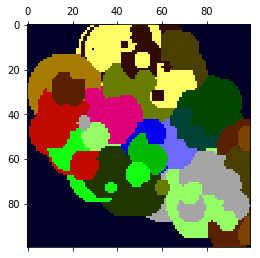

In [188]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(datadict["cm"].T)

plt.matshow(data.getLabels(), cmap=cmap)
print("Hier die klassifizierte Karte visualisiert:")
plt.show()